In [1]:
import os
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data_frame['filename'].iloc[index])
        caption = self.data_frame['impression'].iloc[index]

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, caption

In [3]:
image_dir = "Dataset\Indiana University - Chest X-Rays\images\images"
image_caption_csv_path = "Dataset\Indiana University - Chest X-Rays\indiana_chest_xray_captions.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ChestXrayDataset(csv_file=image_caption_csv_path, img_dir=image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

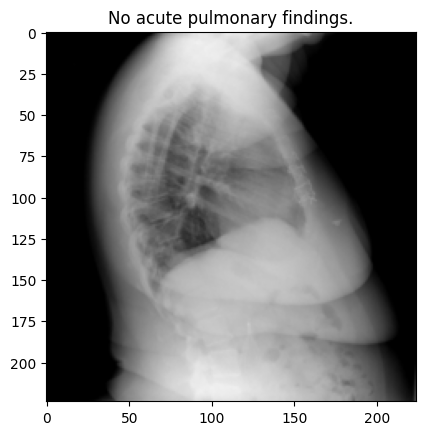

In [4]:
image, caption = dataset.__getitem__(3)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{caption}")
plt.show()

In [5]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, image_encoder, hidden_size, patch_size, num_decoder_layers=8):
        super(MaskedAutoencoder, self).__init__()
        self.image_encoder = image_encoder  # Use shared image encoder
        self.hidden_size = hidden_size
        self.patch_size = patch_size

        # Define an 8-layer transformer for decoding
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=8)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Learnable placeholder embedding for masked patches
        self.mask_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        
        # Linear layer as prediction head to reconstruct pixel values of masked patches
        self.prediction_head = nn.Linear(hidden_size, patch_size * patch_size * 3)

    def forward(self, x, mask_probability=0.15):
        # Extract patch embeddings from the image encoder
        vit_output = self.image_encoder(pixel_values=x)
        patch_embeddings = vit_output.last_hidden_state[:, 1:, :]  # Remove class token
        
        # Apply masking to patch embeddings
        masked_embeddings, mask = self.apply_mask(patch_embeddings, mask_probability)
        
        # Decode the embeddings with context from unmasked patches
        decoded_embeddings = self.decoder(masked_embeddings, patch_embeddings)
        
        # Reconstruct the pixel values of each patch with the prediction head
        reconstructed_patches = self.prediction_head(decoded_embeddings)
        
        return reconstructed_patches, mask

    def apply_mask(self, patch_embeddings, mask_probability):
        batch_size, num_patches, hidden_size = patch_embeddings.shape
        mask = (torch.rand(batch_size, num_patches, device=patch_embeddings.device) < mask_probability)
        
        # Replace masked patches with the mask token
        mask_token_expanded = self.mask_token.expand(batch_size, num_patches, hidden_size)
        masked_embeddings = torch.where(mask.unsqueeze(-1), mask_token_expanded, patch_embeddings)

        return masked_embeddings, mask
    
    def patchify(self, x):
        """
        Reshape the image into patches (B, C, H, W) -> (B, num_patches, patch_size*patch_size*C)
        """
        B, C, H, W = x.shape
        x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 3, 5, 1).reshape(B, -1, self.patch_size * self.patch_size * C)
        return x



def masked_loss(mae_model, reconstructed_patches, original_images, mask):
    """
    Calculate L2 loss only on masked patches.
    """
    # Convert the original image into patches
    original_patches = mae_model.patchify(original_images)
    
    # Expand the mask to match the shape of original_patches along the channel dimension
    mask = mask.unsqueeze(-1).expand_as(original_patches)
    
    # Apply mask to both original and reconstructed patches to calculate loss only for masked patches
    masked_original = original_patches * mask
    masked_reconstructed = reconstructed_patches * mask
    
    # Calculate MSE loss on masked patches
    loss_fn = nn.MSELoss()
    loss = loss_fn(masked_reconstructed, masked_original)
    
    return loss


In [6]:
# Initialize shared encoders
shared_image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
shared_text_encoder = BertModel.from_pretrained('bert-base-uncased').encoder.layer[:6]  # First 6 layers for text encoding
shared_multimodal_encoder = BertModel.from_pretrained('bert-base-uncased').encoder.layer[6:]  # Last 6 layers for multimodal encoding

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

mim_model = MaskedAutoencoder(shared_image_encoder, hidden_size=768, patch_size=16).to(device)

images, _ = next(iter(data_loader))  # Assuming data_loader provides image-only batches
images = images.to(device)
reconstructed_patches, mask = mim_model(images)
loss = masked_loss(mim_model, reconstructed_patches, images, mask)

print("Reconstructed Patches Shape:", reconstructed_patches.shape)
print("Mask Shape:", mask.shape)
print("Loss on Masked Patches:", loss.item())

Reconstructed Patches Shape: torch.Size([8, 196, 768])
Mask Shape: torch.Size([8, 196])
Loss on Masked Patches: 0.10647851228713989


In [ ]:
def train_mim_model(mae_model, image_encoder, data_loader, device, num_epochs=3, learning_rate=1e-4, checkpoint_path="mim_checkpoint.pth", encoder_checkpoint_path="image_encoder_checkpoint.pth"):
    """
    Train the Masked Image Modeling (MIM) model with checkpointing.
    
    Parameters:
    - mae_model: MaskedAutoencoder instance.
    - image_encoder: Shared Vision Transformer model (ViT).
    - data_loader: DataLoader instance with training data.
    - device: torch.device, either 'cuda' or 'cpu'.
    - num_epochs: int, number of training epochs.
    - learning_rate: float, learning rate for optimizer.
    - checkpoint_path: str, path to save/load model checkpoint.
    - encoder_checkpoint_path: str, path to save/load the shared image encoder checkpoint.
    """
    optimizer = optim.Adam(mae_model.parameters(), lr=learning_rate)

    # Load checkpoint if it exists
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        # Load MaskedAutoencoder checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        mae_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch + 1}")
        
    # Load the shared image encoder separately if it exists
    if os.path.exists(encoder_checkpoint_path):
        image_encoder.load_state_dict(torch.load(encoder_checkpoint_path, map_location=device))
        print("Loaded shared image encoder checkpoint.")

    for epoch in range(start_epoch, num_epochs):
        mae_model.train()  # Sets all submodules within mae_model, including image_encoder, to training mode
        total_loss = 0

        for i, (images, _) in enumerate(data_loader):
            images = images.to(device)
            
            optimizer.zero_grad()

            # Forward pass through the model
            reconstructed_patches, mask = mae_model(images, mask_probability=0.15)
            
            # Calculate loss on the masked patches
            loss = masked_loss(mae_model, reconstructed_patches, images, mask)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Print progress every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(data_loader)}], Loss: {total_loss / (i + 1):.4f}")

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Save model and encoder checkpoints
        torch.save({
            'epoch': epoch,
            'model_state_dict': mae_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        # torch.save(image_encoder.state_dict(), encoder_checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")

    print("Training complete.")

In [9]:
train_mim_model(mim_model, shared_image_encoder, data_loader, device, num_epochs=1, learning_rate=1e-4, checkpoint_path="mim_checkpoint.pth", encoder_checkpoint_path="image_encoder_checkpoint.pth")

Epoch [1/1], Batch [10/927], Loss: 0.0324
Epoch [1/1], Batch [20/927], Loss: 0.0222
Epoch [1/1], Batch [30/927], Loss: 0.0188
Epoch [1/1], Batch [40/927], Loss: 0.0173
Epoch [1/1], Batch [50/927], Loss: 0.0162
Epoch [1/1], Batch [60/927], Loss: 0.0153
Epoch [1/1], Batch [70/927], Loss: 0.0146
Epoch [1/1], Batch [80/927], Loss: 0.0140
Epoch [1/1], Batch [90/927], Loss: 0.0134
Epoch [1/1], Batch [100/927], Loss: 0.0130
Epoch [1/1], Batch [110/927], Loss: 0.0126
Epoch [1/1], Batch [120/927], Loss: 0.0122
Epoch [1/1], Batch [130/927], Loss: 0.0118
Epoch [1/1], Batch [140/927], Loss: 0.0115
Epoch [1/1], Batch [150/927], Loss: 0.0113
Epoch [1/1], Batch [160/927], Loss: 0.0111
Epoch [1/1], Batch [170/927], Loss: 0.0109
Epoch [1/1], Batch [180/927], Loss: 0.0107
Epoch [1/1], Batch [190/927], Loss: 0.0106
Epoch [1/1], Batch [200/927], Loss: 0.0104
Epoch [1/1], Batch [210/927], Loss: 0.0102
Epoch [1/1], Batch [220/927], Loss: 0.0101
Epoch [1/1], Batch [230/927], Loss: 0.0099
Epoch [1/1], Batch [

In [ ]:
# # Initialize device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the models
# shared_image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)
# mae_model = MaskedAutoencoder(image_encoder=shared_image_encoder, hidden_size=768, patch_size=16).to(device)

# # Load model checkpoint if it exists
# if os.path.exists("mim_checkpoint.pth"):
#     checkpoint = torch.load("mim_checkpoint.pth", map_location=device)
#     mae_model.load_state_dict(checkpoint['model_state_dict'])
#     print("Loaded MaskedAutoencoder checkpoint.")

# if os.path.exists("image_encoder_checkpoint.pth"):
#     shared_image_encoder.load_state_dict(torch.load("image_encoder_checkpoint.pth", map_location=device))
#     print("Loaded shared image encoder checkpoint.")

# # Now you can proceed to test or continue training with mae_model and shared_image_encoder.


In [10]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def test_mim_model(mae_model, image, device, mask_probability=0.15):
    """
    Tests the MIM model on a single image sample.
    
    Parameters:
    - mae_model: MaskedAutoencoder instance
    - image: torch.Tensor, single image with shape (C, H, W)
    - device: torch.device
    - mask_probability: float, probability of masking each patch
    """
    mae_model.eval()  # Set the model to evaluation mode
    
    # Prepare the image
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Forward pass through the model
    with torch.no_grad():
        reconstructed_patches, mask = mae_model(image, mask_probability=mask_probability)
    
    # Patchify the original image
    original_patches = mae_model.patchify(image)
    
    # Reshape mask to match the shape of patches for reconstruction
    mask = mask.unsqueeze(-1).expand_as(original_patches)
    
    # Create the masked image by zeroing out masked patches in the original image
    masked_image_patches = original_patches * (~mask)
    masked_image = unpatchify(masked_image_patches, mae_model.patch_size, image.shape[-2:])
    
    # Reconstruct the original image by combining masked and unmasked patches
    reconstructed_image_patches = original_patches * (~mask) + reconstructed_patches * mask
    reconstructed_image = unpatchify(reconstructed_image_patches, mae_model.patch_size, image.shape[-2:])

    # Display the original, masked, and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(ToPILImage()(image.squeeze(0).cpu()))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(ToPILImage()(masked_image.squeeze(0).cpu()))
    ax[1].set_title("Masked Image")
    ax[1].axis("off")
    
    ax[2].imshow(ToPILImage()(reconstructed_image.squeeze(0).cpu()))
    ax[2].set_title("Reconstructed Image (Masked Patches)")
    ax[2].axis("off")
    plt.show()

def unpatchify(patches, patch_size, image_size):
    """
    Reconstructs an image from patches.
    
    Parameters:
    - patches: torch.Tensor, shape (B, num_patches, patch_size*patch_size*C)
    - patch_size: int, the size of each patch (e.g., 16 for 16x16 patches)
    - image_size: tuple, original image size (H, W)
    
    Returns:
    - torch.Tensor, reconstructed image of shape (B, C, H, W)
    """
    B, num_patches, _ = patches.shape
    C = patches.shape[-1] // (patch_size * patch_size)
    H, W = image_size
    
    patches = patches.view(B, H // patch_size, W // patch_size, patch_size, patch_size, C)
    patches = patches.permute(0, 5, 1, 3, 2, 4)  # (B, C, H_p, pH, W_p, pW)
    return patches.reshape(B, C, H, W)


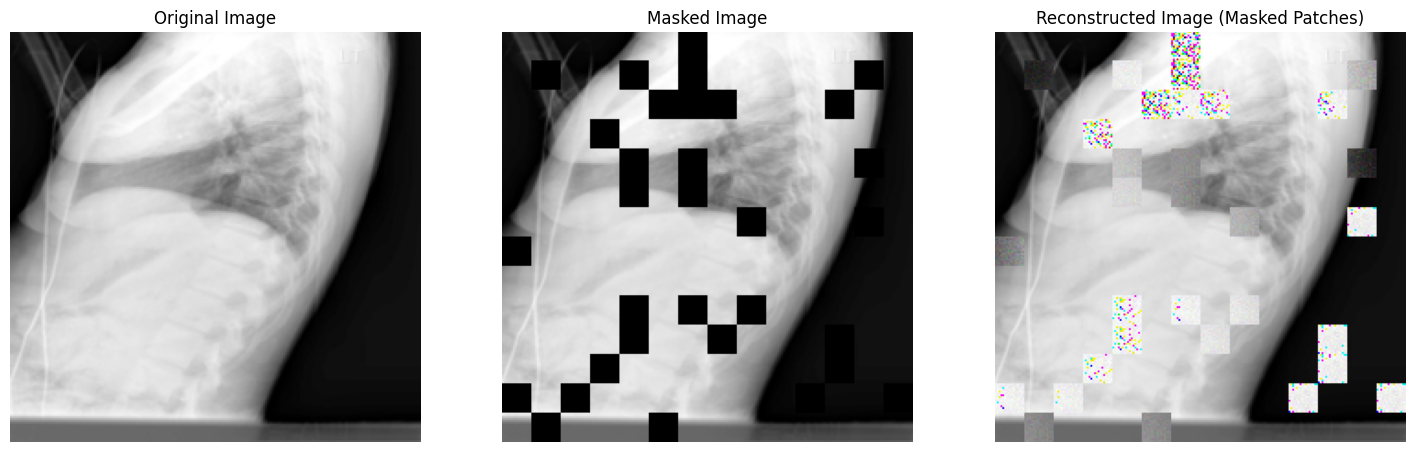

In [12]:
# Example usage
# Load a sample from the dataset (assuming dataset is an instance of ChestXrayDataset)
sample_image, _ = dataset[-1]  # Load a single image (no caption needed for MIM)

# Test the MIM model on the sample image
test_mim_model(mim_model, sample_image, device)